This notebook generates the following manuscript mapped analyses:

* Trends in ANF (Figure 1)
* Trends in FWSL and VPD (Figure 2A&B)
* (Dis)agreement between ANF and climate (Figures 2C&D)
* Correlation between ANF and climate (Extended Figure 3C&D)
* Mapped GFED regions (Extended Figure 3A)
* Mean annual AVHRR fire counts (1986-2016, 2degree grid cells) (Extended Figure 3B)

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

setup custom color maps for plotting

In [2]:
# 1 colour cmap (grey) used to indicate frequent fire activity
flat_cmap = mpl.colors.ListedColormap(['#b3b3b3', '#b3b3b3'])

# 1 colour cmap (blue) used in supp mat. maps
flat_cmap_blue = mpl.colors.ListedColormap(['#6495ED', '#6495ED'])

# 5 colour discrete cmap used for comparing trend in fire and VPD/FWSL
discrete_cmap_list = [[30, 120, 180], # blue
                      [202, 0, 32],  # red
                      [239, 209, 69],  # yellow
                      [127, 205, 187],  # teal
                      [255, 255, 255]]  # white
discrete_cmap = utils.list_to_listed_cmap(discrete_cmap_list)

setup paths

In [3]:
dir_base = Path(paths.dir_main)
dir_avhrr = dir_base

#input/output data dirs
dir_fwsl = dir_base / "03_fire_weather/03_resampled/"
dir_vpd = dir_base / "04_vpd/03_resampled/"
dir_out_figures = dir_base / "outputs"

# input file paths
fp_avhrr = dir_avhrr / "avhrr_gridded_0_1_deg_annual_1986_2016.npy"
fp_fwi = dir_fwsl / "fwi_days_ensemble_gfwed_and_geff_1986_2016_resampled_0p1deg.npz"
fp_vpd = dir_vpd / "vpd_mean_1986_2016_resampled_0p1deg.npz"

# gfed region data: need to plot gfed regions for context in supplemental fig
fp_gfed = dir_base / "aux_data/gfed/gfed_regions_0_1_deg.npy"

Define user inputs and setup global grid parameters

In [4]:
# if coarsen > 1, spatial resolution will be coarsened by aggregating this 
# many input grid cells (if input is 0.1 deg, coarsen == 20 -> 2 degree grid)
coarsen = 20
# list of years to compile
all_years = np.arange(1986,2016+1)
# define input grid parameters
res = 0.1
# matplotlib expects plotting in inches, this conversion factor lets us specify it in mm
mm = 1/25.4

In [5]:
# get evenly spaced lat/lons
lat1d_raw = np.linspace(90. - res / 2., -90. + res / 2., num=int(180 / res))
lon1d_raw = np.linspace(0. + res / 2., 360. - res / 2., num=int(360 / res)) - 180
offset_raw = abs(lon1d_raw[0] - lon1d_raw[1]) / 2
lon2d_raw, lat2d_raw = np.meshgrid(lon1d_raw, lat1d_raw)

# recalc these if inputs should be coarsened
if coarsen != 1:
    lat1d = np.linspace(lat1d_raw[:coarsen].mean(), lat1d_raw[-coarsen:].mean(), int(lat1d_raw.shape[0] / coarsen))
    lon1d = np.linspace(lon1d_raw[:coarsen].mean(), lon1d_raw[-coarsen:].mean(), int(lon1d_raw.shape[0] / coarsen))
else:
    lat1d = lat1d_raw
    lon1d = lon1d_raw

# get corresponding 2D grids of lat/lon
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

#useful for plotting
pixel_spacing = int(lat1d[0] - lat1d[1])
offset = abs(lon1d[0] - lon1d[1]) / 2

In [6]:
# load AVHRR data
av = np.load(fp_avhrr)
av = np.roll(av, 1800, axis=2)

# sum fire counts to a coarser grid if required
if coarsen != 1:
    print(f'old dims: {av.shape}')
    av = utils.grid_coarsen(arr=av, c=coarsen)
    print(f'new dims: {av.shape}')

# use this coarsened data in R to look at change points
np.save(str(dir_avhrr / 'avhrr_gridded_0_1_deg_annual_1986_2016_aggregated_2deg.npy'), av)

old dims: (31, 1800, 3600)
new dims: (31, 90, 180)


make mean fire activity plot and gfed region plot for supplement

In [7]:
# calculate the mean grid cell fire count for the AVHRR years we use within 1986-2016
av_mean = np.nanmean(av, axis=0)
av_mean[av_mean==0] = np.nan

#mask some inconsequential but distracting small island activity 
av_mean[44:46,43:45] = np.nan
av_mean[51:55,172:179] = np.nan

### 1) Trends in ANF (Figure 1)
* calculate ANF trends (kendalls) for all grid cells, and plot. 

In [8]:
# calculate statistics (Kendall's tau and sen slope) over entire grid
av_t, av_t_p, av_sen = utils.grid_kendall_no_nan_v2(av[:, :, :], all_years, norm=True, thresh=0.6)

# mask based on p < 0.1 ~~~~
av_t_pval_mask = (av_t_p < 0.1).astype(float)
av_t_pval_mask[av_t_pval_mask == 0] = np.nan

# apply mask
av_t_masked = av_t * av_t_pval_mask

In [9]:
# binary array of frequent fire locations based on mean fire activity
firescount = np.zeros_like(av_mean) * np.nan
firescount[av_mean>=1] = 1

freq fire grid cells: 2045
no of sig trends: 415


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


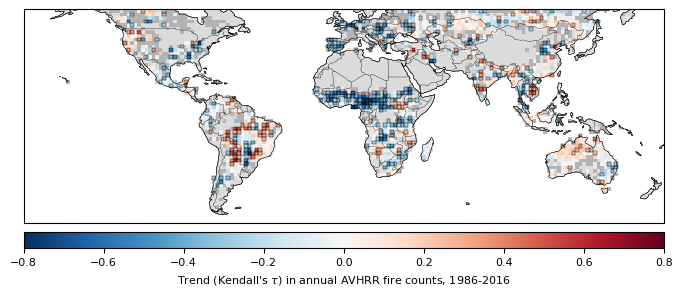

In [10]:
# get locations of significant (p < 0.1) points
y, x = np.where(~np.isnan(av_t_masked))
y = lat2d[np.where(~np.isnan(av_t_masked))]
x = lon2d[np.where(~np.isnan(av_t_masked))]

# calc and print some stats for info ====
nf = np.sum(~np.isnan(firescount))
nn = y.shape[0]
print('freq fire grid cells:', nf)
print('no of sig trends:', nn)

# make a plot with frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                                lons=lon1d,# - offset, 
                                lats=lat1d, #+ offset, 
                                extent = [-180, 180, -60, 66],
                                arr=firescount,
                                grid_options=None,
                                mesh_options={'norm': mpl.colors.Normalize(), 
                                              'cmap': flat_cmap},
                                draw_features=['land', 'coast', 'countries']
                             )

# now add the grid cells with trends (all significance)
ax, mesh = utils.geo_plot_ax(fig, ax, 
                       lons=lon1d,# - offset,
                       lats=lat1d,# - offset,
                       extent = [-180, 180, -60, 60],
                       arr=av_t,
                       grid_options=None,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=-0.8, vmax=0.8), 
                                     'cmap': 'RdBu_r'}
                         )

# add square markers where p < 0.1
ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab=r"Trend (Kendall's $\tau$) in annual " 
                "AVHRR fire counts, 1986-2016", 
                cbax_options={'location': 'bottom', 'pad': 0.01, 'shrink': 1, 'aspect': 40}, # 'pad': 0.05 'shrink': 1, 'aspect': 40
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / '01_avhrr_fire_trend_map.png'), dpi=1000)
np.save(str(dir_out_figures / '01_avhrr_fire_trend_map_tau.npy'), av_t)
np.save(str(dir_out_figures / '01_avhrr_fire_trend_map_tau_masked_to_pval0p1.npy'), av_t_masked)
#fig.savefig(str(dir_out_figures / '01_avhrr_fire_trend_map.pdf'))

### 2) Trend in Fire Weather Season Length
* FWSL is based on the combined ensemble of all GFWED and GEFF outputs (fwi_days_ensemble_gfwed_and_geff_1986_2016_resampled_0p1deg.npz)
* grid_coarsen() is different to that used for ANF, as we need to calculate the MEAN not sum. This also requires a few intermediate steps to account for the effect of NaNs

In [11]:
efwsl = np.load(fp_fwi)['arr_0']
efwsl.shape

(31, 1800, 3600)

In [12]:
# identify nans with mask
nan_mask = np.isnan(efwsl).astype(int)
if len(nan_mask.shape) < 3:
    nan_mask = nan_mask[np.newaxis,:,:]
efwsl[np.isnan(efwsl)] = 1 # turn all nans into 1s

# calculate SUM at new res (this will = x + 1 * no. of nan cells)
efwsl2, lat1d_2, lon1d_2 = utils.grid_coarsen_v2(arr=efwsl, lat1d=lat1d_raw, 
                                           lon1d=lon1d_raw, factor=coarsen, algo='sum')

# how many nans were in each NEW resolution grid cell?
nan_new = np.zeros([nan_mask.shape[0], int(nan_mask.shape[1]/coarsen), int(nan_mask.shape[2]/coarsen)])   
for z in range(nan_mask.shape[0]):
    for i in range(coarsen):
        for j in range(coarsen):
            nan_new[z] += nan_mask[z,i::coarsen, j::coarsen]
print(nan_new.shape)

# remove influence of nans (1s) from sum 
efwsl2 = efwsl2 - nan_new

# calc mean by dividing by the number of valid (non-nan) grid cells
# 100% nan cells get reset to NaN due to dividebyzero
nvalid = coarsen**2 - nan_new
efwsl2 = efwsl2 / nvalid

# mask the arctic 
#1 grid cell = 2deg so 15 grid cells = 30deg (90-30=60)
efwsl2[:,0:15,:] = np.nan

(31, 90, 180)


C:\Users\mdejong\AppData\Local\Temp\ipykernel_8852\3899094766.py:25: RuntimeWarning: invalid value encountered in divide
  efwsl2 = efwsl2 / nvalid


calculate trends

In [13]:
efwsl_tau, efwsl_tau_p, efwsl_sen = utils.grid_kendall_no_nan_v2(efwsl2, all_years, 
                                                                 norm=False, thresh=1)

# mask based on p < 0.1
efwsl_tau_p_mask = (efwsl_tau_p < 0.1).astype(float)  # 1= sig, 0 = not sig
efwsl_tau_masked = efwsl_tau * efwsl_tau_p_mask  # set not sig areas to zero

C:\Users\mdejong\repos\avhrr-fire\src\05_data_analysis\./../../lib\utils.py:488: RuntimeWarning: invalid value encountered in scalar divide
  extreme_prop = extremes / len(fires)


plot the trends

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


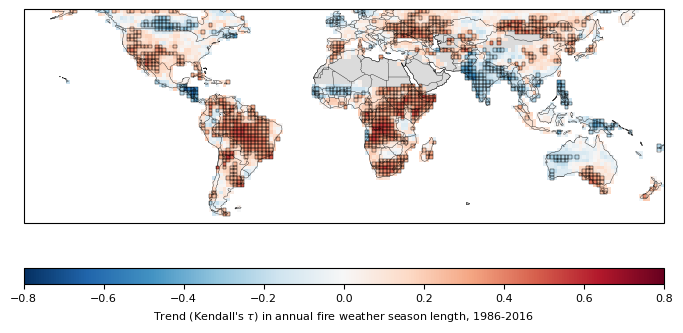

In [14]:
y = lat2d[np.where((efwsl_tau_masked!=0)&(~np.isnan(efwsl_tau_masked)))]
x = lon2d[np.where((efwsl_tau_masked!=0)&(~np.isnan(efwsl_tau_masked)))]

fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60],
                            arr=efwsl_tau,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(vmin=-0.8, vmax=0.8), 
                                          'cmap': 'RdBu_r'},
                            draw_features=['land', 'coast', 'countries']#'lakes'
                           )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k',
           facecolor='none',
           linewidth=0.3)

utils.colorbar_v4(fig, ax, mesh, cblab=r"Trend (Kendall's $\tau$) in annual fire weather season length, 1986-2016", 
            cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 40}, 
            cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / '02_fwsl_trend_map.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / '02_fwsl_trend_map.pdf'))

### 3) VPD
* do exactly the same for VPD as for FWSL

In [15]:
vpd = np.load(fp_vpd)['arr_0']
vpd.shape

(31, 1800, 3600)

In [16]:
# identify nans with mask
nan_mask = np.isnan(vpd).astype(int)
if len(nan_mask.shape) < 3:
    nan_mask = nan_mask[np.newaxis,:,:]
vpd[np.isnan(vpd)] = 1 # turn all nans into 1s

# calculate SUM at new res (this will = x + 1 * no. of nan cells)
vpd2, lat1d_2, lon1d_2 = utils.grid_coarsen_v2(arr=vpd, lat1d=lat1d_raw, 
                                         lon1d=lon1d_raw, factor=coarsen, algo='sum')

# how many nans were in each NEW resolution grid cell?
nan_new = np.zeros([nan_mask.shape[0], int(nan_mask.shape[1]/coarsen), int(nan_mask.shape[2]/coarsen)])   
for z in range(nan_mask.shape[0]):
    for i in range(coarsen):
        for j in range(coarsen):
            nan_new[z] += nan_mask[z,i::coarsen,j::coarsen]
print(nan_new.shape)

# remove influence of nans (1s) from sum 
vpd2 = vpd2 - nan_new

# calc mean by dividing by the number of valid (non-nan) cells
# 100% nan cells get reset to NaN due to dividebyzero
nvalid = coarsen**2 - nan_new
vpd2 = vpd2 / nvalid

# mask the arctic 
#1 grid cell = 2deg so 15 grid cells = 30deg (90-30=60)
vpd2[:,0:15,:] = np.nan

(31, 90, 180)


C:\Users\mdejong\AppData\Local\Temp\ipykernel_8852\1496873676.py:25: RuntimeWarning: invalid value encountered in divide
  vpd2 = vpd2 / nvalid


calculate trends

In [17]:
vpd_tau, vpd_tau_p, vpd_sen = utils.grid_kendall_no_nan_v2(vpd2, all_years, 
                                                     norm=False, thresh=1)

# mask based on p < 0.1
vpd_tau_p_mask = (vpd_tau_p < 0.1).astype(float)  # 1= sig, 0 = not sig
vpd_tau_masked = vpd_tau * vpd_tau_p_mask  # set not sig areas to zero

C:\Users\mdejong\repos\avhrr-fire\src\05_data_analysis\./../../lib\utils.py:488: RuntimeWarning: invalid value encountered in scalar divide
  extreme_prop = extremes / len(fires)


plot trends

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


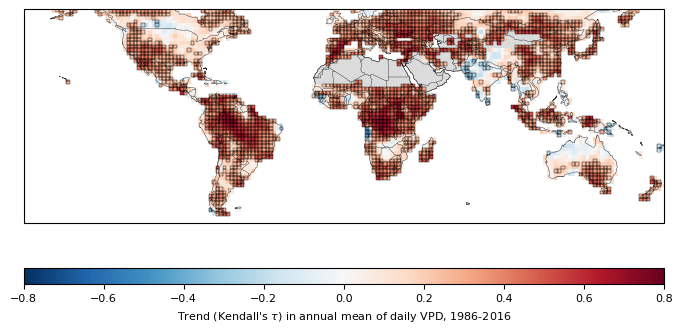

In [18]:
y = lat2d[np.where((vpd_tau_masked!=0)&(~np.isnan(vpd_tau_masked)))]
x = lon2d[np.where((vpd_tau_masked!=0)&(~np.isnan(vpd_tau_masked)))]

fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d,
                            lats=lat2d,
                            extent = [-180, 180, -60, 60],
                            arr=vpd_tau,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(vmin=-0.8, vmax=0.8), 
                                          'cmap': 'RdBu_r'},
                            draw_features=['land', 'coast', 'countries']
                           )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k',
           facecolor='none',
           linewidth=0.3)

utils.colorbar_v4(fig, ax, mesh, cblab=r"Trend (Kendall's $\tau$) in annual mean of daily VPD, 1986-2016", 
            cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 40}, 
            cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / '02_vpd_trend_map.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / '02_vpd_trend_map.pdf'))

### 4) (dis)agreement between fire and climate plots

In [19]:
# the array of AVHRR Kendalls tau where p value < 0.1
fires=av_t_masked.copy()  

FWSL version

grid cells with frequent fire: 2045
grid cells with a fire trend: 415
total coincident trends: 177 42.65060240963855
both down: 23 5.542168674698795
both up: 51 12.289156626506024
fire up climate down: 9 2.1686746987951806
fire down climate up: 94 22.650602409638555
fire trend but no climate trend: 238 57.34939759036145
n agreeing: 74 17.83132530120482
NOTE: discrete colorbar specified. ensure that ticks match ticklabs! tickrange=1-5 clim=0.5-5.5, offset=0.5


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


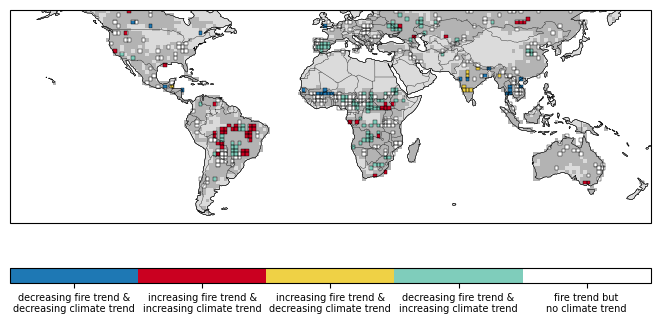

In [20]:
fwsl_quadrant = np.ones_like(fires) * np.nan
fwsl_quadrant[~np.isnan(fires)] = 5  #this will be the locations where trend in fire but no trend in fw
fwsl_quadrant[(efwsl_tau_masked<0)&(fires<0)] = 1
fwsl_quadrant[(efwsl_tau_masked>0)&(fires>0)] = 2
fwsl_quadrant[(efwsl_tau_masked<0)&(fires>0)] = 3
fwsl_quadrant[(efwsl_tau_masked>0)&(fires<0)] = 4

# fwsl_quadrant has values 1-4 & nan
nf = np.sum(~np.isnan(firescount))
nn = np.sum(~np.isnan(fwsl_quadrant))
n1 = np.sum(fwsl_quadrant==1)
n2 = np.sum(fwsl_quadrant==2)
n3 = np.sum(fwsl_quadrant==3)
n4 = np.sum(fwsl_quadrant==4)
n5 = np.sum(fwsl_quadrant==5)
print('grid cells with frequent fire:', nf)
print('grid cells with a fire trend:', nn)
print('total coincident trends:', n1+n2+n3+n4, (n1+n2+n3+n4)/nn*100)
print('both down:', n1, n1/nn*100)
print('both up:', n2, n2/nn*100)
print('fire up climate down:', n3, n3/nn*100)
print('fire down climate up:', n4, n4/nn*100)
print('fire trend but no climate trend:', n5, n5/nn*100)
print('n agreeing:', n1+n2, (n1+n2)/nn*100)

ticks = [1,2,3,4,5]

tick_labs = [f'decreasing fire trend &\ndecreasing climate trend',
             f'increasing fire trend &\nincreasing climate trend',
             f'increasing fire trend &\ndecreasing climate trend',
             f'decreasing fire trend &\nincreasing climate trend',
             f'fire trend but\nno climate trend']


y = lat2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]
x = lon2d[np.where((fwsl_quadrant!=0)&(~np.isnan(fwsl_quadrant)))]


fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d,
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=firescount,
                            grid_options=False,
                         mesh_options={'norm': mpl.colors.Normalize(), 
                                       'cmap': flat_cmap
                                      },
                            draw_features=['land', 'coast', 'countries']#'lakes'                            
                         )

ax, mesh = utils.geo_plot_ax(fig, ax, 
                             lons=lon2d,
                             lats=lat2d,
                             extent = [-180, 180, -60, 60], 
                             arr=fwsl_quadrant,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': discrete_cmap
                                      },
                       grid_options=False
                         )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab="", 
                fontsize=7,
                ticks=ticks, ticklab=tick_labs, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / '02_fwsl_quadrant_map.png'), dpi=1000)
fig.savefig(str(dir_out_figures / '02_fwsl_quadrant_map.pdf'))

VPD version

grid cells with frequent fire: 2045
grid cells with a fire trend: 415
total coincident trends: 282 67.95180722891565
both down: 1 0.24096385542168677
both up: 86 20.722891566265062
fire up climate down: 0 0.0
fire down climate up: 195 46.98795180722892
fire trend but no climate trend: 133 32.04819277108434
n agreeing: 87 20.96385542168675
NOTE: discrete colorbar specified. ensure that ticks match ticklabs! tickrange=1-5 clim=0.5-5.5, offset=0.5


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


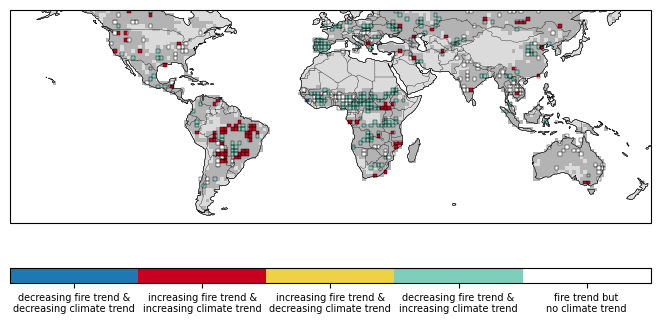

In [21]:
vpd_quadrant = np.ones_like(fires) * np.nan
vpd_quadrant[~np.isnan(fires)] = 5  #this will be the locations where trend in fire but no trend in fw
vpd_quadrant[(vpd_tau_masked<0)&(fires<0)] = 1
vpd_quadrant[(vpd_tau_masked>0)&(fires>0)] = 2
vpd_quadrant[(vpd_tau_masked<0)&(fires>0)] = 3
vpd_quadrant[(vpd_tau_masked>0)&(fires<0)] = 4

# vpd_quadrant has values 1-4 & nan
nf = np.sum(~np.isnan(firescount))
nn = np.sum(~np.isnan(vpd_quadrant))
n1 = np.sum(vpd_quadrant==1)
n2 = np.sum(vpd_quadrant==2)
n3 = np.sum(vpd_quadrant==3)
n4 = np.sum(vpd_quadrant==4)
n5 = np.sum(vpd_quadrant==5)
print('grid cells with frequent fire:', nf)
print('grid cells with a fire trend:', nn)
print('total coincident trends:', n1+n2+n3+n4, (n1+n2+n3+n4)/nn*100)
print('both down:', n1, n1/nn*100)
print('both up:', n2, n2/nn*100)
print('fire up climate down:', n3, n3/nn*100)
print('fire down climate up:', n4, n4/nn*100)
print('fire trend but no climate trend:', n5, n5/nn*100)
print('n agreeing:', n1+n2, (n1+n2)/nn*100)

ticks = [1,2,3,4,5]

tick_labs = [f'decreasing fire trend &\ndecreasing climate trend',
             f'increasing fire trend &\nincreasing climate trend',
             f'increasing fire trend &\ndecreasing climate trend',
             f'decreasing fire trend &\nincreasing climate trend',
             f'fire trend but\nno climate trend']


y = lat2d[np.where((vpd_quadrant!=0)&(~np.isnan(vpd_quadrant)))]
x = lon2d[np.where((vpd_quadrant!=0)&(~np.isnan(vpd_quadrant)))]


fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=firescount,
                            grid_options=False,
                         mesh_options={'norm': mpl.colors.Normalize(), 
                                       'cmap': flat_cmap
                                      },
                            draw_features=['land', 'coast', 'countries']#'lakes'                            
                         )

ax, mesh = utils.geo_plot_ax(fig, ax, lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=vpd_quadrant,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': discrete_cmap
                                      },
                       grid_options=False
                         )

ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=7, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, 
                cblab="", 
                fontsize=7,
                ticks=ticks, ticklab=tick_labs, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / '02_vpd_quadrant_map.png'), dpi=1000)
fig.savefig(str(dir_out_figures / '02_vpd_quadrant_map.pdf'))

### 5) Supplemental figure 3
* A) GFED basis regions
* B) Mean fire counts
* C) VPD & ANF correlation
* D) FWSL & ANF correlation

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


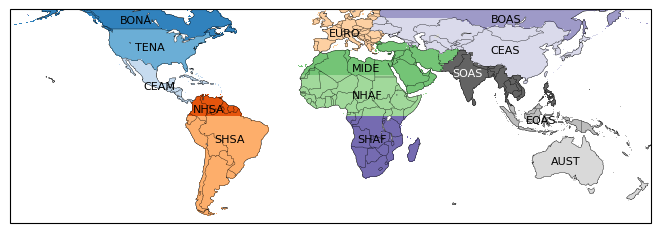

In [22]:
# load the GFED basis regions raster and plot it
gfed = np.load(fp_gfed)
gfed = np.roll(gfed, 1800)
#print(np.unique(gfed))
gfed[gfed == 0] = np.nan

grid_options = {'color': 'lightgrey', 'linestyle': '--', 'alpha': 0.7, 'draw_labels': True}

fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon2d_raw, # - offset, 
                            lats=lat2d_raw, # + offset,
                            extent = [-180, 180, -60, 60], 
                            arr=gfed,
                            grid_options=None,
                         mesh_options={'norm': mpl.colors.Normalize(), 
                                       'cmap': 'tab20c'
                                      }
                         )

fontsize=8
ax.text(-118, 52, 'BONA', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(-110, 37, 'TENA', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(-105, 15, 'CEAM', transform=ccrs.PlateCarree(), fontsize=fontsize)
ax.text(-77, 2, 'NHSA', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(-65, -15, 'SHSA', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')

ax.text(-1, 45, 'EURO', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(12, 25, 'MIDE', transform=ccrs.PlateCarree(), fontsize=fontsize)
ax.text(12, 10, 'NHAF', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(15, -15, 'SHAF', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')

ax.text(90, 52.5, 'BOAS', transform=ccrs.PlateCarree(), fontsize=fontsize, c='k')
ax.text(90, 35, 'CEAS', transform=ccrs.PlateCarree(), fontsize=fontsize)
ax.text(68.5, 22.5, 'SOAS', transform=ccrs.PlateCarree(), fontsize=fontsize, c='white')
ax.text(110, -4, 'EQAS', transform=ccrs.PlateCarree(), fontsize=fontsize)
ax.text(124, -27, 'AUST', transform=ccrs.PlateCarree(), fontsize=fontsize)

# output
fig.savefig(str(dir_out_figures / 's3a_GFED_basis_regions_map_tab20c.png'), dpi=1000)
# caution, this file as a vector (pdf) is HUGE! best to just use the png raster version.
#fig.savefig(str(dir_out_figures / 's3a_GFED_basis_regions_map_tab20c.pdf')) 

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


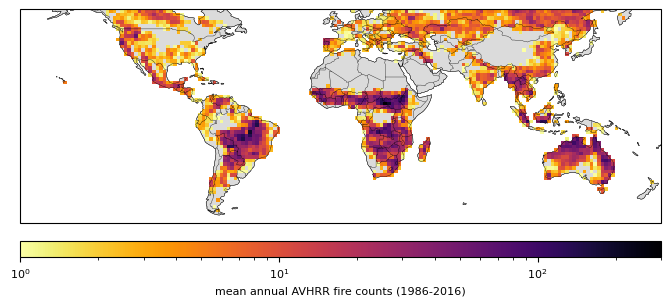

In [23]:
# plot the mean array
tmp = av_mean.copy()
tmp[tmp < 1] = np.nan
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon1d, #- offset, 
                            lats=lat1d, # + offset, 
                            extent = [-180, 180, -60, 60],
                            arr=tmp,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.LogNorm(vmin=1,vmax=300), 
                                          'cmap': 'inferno_r'#, 
                                          #'vmin': 1, 'vmax': 300
                                         },
                            draw_features=['land', 'coast', 'countries']
                         )

utils.colorbar_v4(fig, ax, mesh, cblab= "mean annual AVHRR fire counts (1986-2016)", 
            cbax_options={'location': 'bottom', 'pad': 0.02, 'shrink': 1, 'aspect': 40}, #aspect=40 shrin=1
            cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / 's3b_mean_annual_fire_counts.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's3b_mean_annual_fire_counts.pdf'))

VPD correlation

In [24]:
tau_fd, tau_p_fd = utils.grid_corr_stat(arr_a=av, arr_b=vpd2, statistic='kendall', do_first_differencing=True)

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


0.6913108819862862


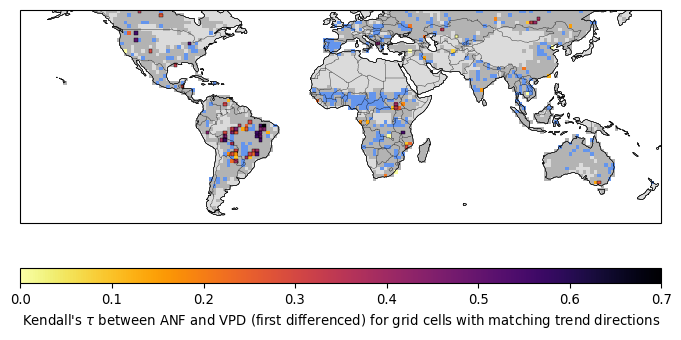

In [25]:
# tau_fd, tau_p_fd
mask = ~np.isnan(fires)
mask = mask.astype(float)
mask[mask==0] = np.nan
#plt.matshow(mask)

mask_match = (vpd_quadrant <= 2)
mask_match = mask_match.astype(float)
mask_match[mask_match==0] = np.nan
#plt.matshow(mask_match)

mask_match_sig = (vpd_quadrant <= 2) & (tau_p_fd < 0.1)
mask_match_sig = mask_match_sig.astype(float)
mask_match_sig[mask_match_sig==0] = np.nan
#plt.matshow(mask_match_sig)

y = lat2d[(~np.isnan(mask_match_sig))]
x = lon2d[(~np.isnan(mask_match_sig))]

#frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon1d, 
                            lats=lat1d, 
                            extent = [-180, 180, -60, 66],
                            arr=firescount,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(), 
                                          'cmap': flat_cmap},
                            draw_features=['land', 'coast', 'countries']
                         )

# locations where trends disagree
ax, mesh = utils.geo_plot_ax(fig, ax, lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=mask,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': flat_cmap_blue},
                       grid_options=False
                         )

# r2 where r2 p-value < 0.1
tmp = mask_match_sig * tau_fd
print(np.nanmax(tmp))
ax, mesh = utils.geo_plot_ax(fig, ax, lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=mask_match * tau_fd,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=0, vmax=np.round(np.nanmax(tmp),1)), 
                                     'cmap': 'inferno_r'},
                       grid_options=False
                         )
ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=6, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, cblab=r"Kendall's $\tau$ between ANF and VPD (first differenced) for grid cells with matching trend directions", fontsize=9.5, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / 's3c_vpd_trend_correlation_map.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's3c_vpd_trend_correlation_map.pdf'))

FWSL correlation

In [26]:
tau_fd, tau_p_fd = utils.grid_corr_stat(arr_a=av, arr_b=efwsl2, statistic='kendall', do_first_differencing=True)

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


0.6709956709956709


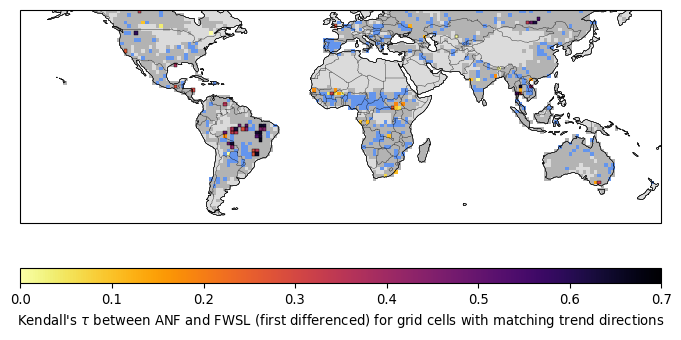

In [27]:
# tau_fd, tau_p_fd
mask = ~np.isnan(fires)
mask = mask.astype(float)
mask[mask==0] = np.nan
#plt.matshow(mask)

mask_match = (fwsl_quadrant <= 2)
mask_match = mask_match.astype(float)
mask_match[mask_match==0] = np.nan
#plt.matshow(mask_match)

mask_match_sig = (fwsl_quadrant <= 2) & (tau_p_fd < 0.1)
mask_match_sig = mask_match_sig.astype(float)
mask_match_sig[mask_match_sig==0] = np.nan
#plt.matshow(mask_match_sig)


# PLOT 2: r squared with significance indicated by squares
mask_match_sig
y = lat2d[(~np.isnan(mask_match_sig))]
x = lon2d[(~np.isnan(mask_match_sig))]

#frequent fire grids
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                            lons=lon1d, 
                            lats=lat1d, 
                            extent = [-180, 180, -60, 66],
                            arr=firescount,
                            grid_options=None,
                            mesh_options={'norm': mpl.colors.Normalize(), 
                                          'cmap': flat_cmap},
                            draw_features=['land', 'coast', 'countries']
                         )

# locations where trends disagree
ax, mesh = utils.geo_plot_ax(fig, ax, lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=mask,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(), 
                                     'cmap': flat_cmap_blue},
                       grid_options=False
                         )

# r2 where r2 p-value < 0.1
tmp = mask_match_sig * tau_fd
print(np.nanmax(tmp))
ax, mesh = utils.geo_plot_ax(fig, ax, lons=lon2d, 
                            lats=lat2d,
                            extent = [-180, 180, -60, 60], 
                            arr=mask_match * tau_fd,
                       coast_options={'linewidth': 0.25, 'resolution': '110m'},
                       mesh_options={'norm': mpl.colors.Normalize(vmin=0, vmax=np.round(np.nanmax(tmp),1)), 
                                     'cmap': 'inferno_r'},
                       grid_options=False
                         )
ax.scatter(y= y - 0,
           x= x + 0,
           marker='s',
           s=6, edgecolor='k', #s=12 
           facecolor='none',
           linewidth=0.3) #s=0.5

utils.colorbar_v4(fig, ax, mesh, cblab=r"Kendall's $\tau$ between ANF and FWSL (first differenced) for grid cells with matching trend directions", fontsize=9.5, 
                cbax_options={'location': 'bottom', 'pad': 0.05, 'shrink': 1, 'aspect': 45}, 
                cb_options={'orientation': 'horizontal', 'extend': 'neither'})

fig.savefig(str(dir_out_figures / 's3d_fwsl_trend_correlation_map.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's3d_fwsl_trend_correlation_map.pdf'))